This notebook should be run on happili-02 <br><br>
This is a look at observation 180503001, which is a first long bandpass scan with compound beams. 3C286 is in compound beam 18, but placed in 00 for purposes of the notebook. 
<br><br>
There are several caveats to the data:
- Coordinates in the header are wrong; all beams have the coordinates of center beam. This originates in the parset and also means all beams have the phase tracking of the center beam.
- RTC has many subbands with poor beamweights. For simplicity, I will flag it.
- There are many subbands at the start of the frequency range with poor beamweights. For simplicity, I will flag up to channel 2000
- There will still be several small subband sets with poor beamweights for different antennas. I'm not sure how this will affect the final data quality

In [1]:
#load apercal automatically, not needing to specify my username/path directly
import os;
myusername = os.environ['USER']
if not ('PYTHONPATH' in os.environ and
        '/home/' + myusername + '/apercal' in os.environ['PYTHONPATH']):
      print("WARNING: your apercal directory should be in the $PYTHONPATH")

In [2]:
#set up logging
%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/{}/apertif/BP/logs/180503001.log'.format(myusername))

/home/apercal/pipeline/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/adams/apertif/BP/logs/180503001.log


Setup logger with lib.setup_logger()


In [56]:
import sys
sys.path.append('/home/adams/apertif/BP')
import apercal
import numpy as np
import os
import subs
import aplpy
import matplotlib.pyplot as plt
import bp
%matplotlib inline
cfgfile ='/home/adams/apertif/BP/cfg/180503001.cfg'
cfgfile_uvedit ='/home/adams/apertif/BP/cfg/180503001_uvedit.cfg'

I copied the data manually, so no need to run prepare module.

In [17]:
preflag = apercal.preflag(cfgfile)
nchannel = 11008 - 2048 #want to automatically flag first chunk of channels, use integer number of subbands

# Make lists of the channels which are affected
a = range(0, nchannel, 64)  # the subband edges
b = range(1, nchannel, 64) 
c = range(63, nchannel, 64) 
d = range(16, nchannel, 64)  # the two ghosts
e = range(48, nchannel, 64) 


# Combine the channel list into one list and convert to a string
l = a + b + c + d + e
#preflag.preflag_manualflag_channel 
chanstring= ';'.join(str(ch+2048) for ch in l)
preflag.preflag_manualflag_channel = '0~2047;'+chanstring
preflag.show()

PREFLAG
	preflag_manualflag = True
	preflag_manualflag_fluxcal = True
	preflag_manualflag_polcal = False
	preflag_manualflag_target = False
	preflag_manualflag_auto = True
	preflag_manualflag_antenna = RTC
	preflag_manualflag_corr = 
	preflag_manualflag_shadow = True
	preflag_manualflag_baseline = 
	preflag_manualflag_channel = 0~2047;2048;2112;2176;2240;2304;2368;2432;2496;2560;2624;2688;2752;2816;2880;2944;3008;3072;3136;3200;3264;3328;3392;3456;3520;3584;3648;3712;3776;3840;3904;3968;4032;4096;4160;4224;4288;4352;4416;4480;4544;4608;4672;4736;4800;4864;4928;4992;5056;5120;5184;5248;5312;5376;5440;5504;5568;5632;5696;5760;5824;5888;5952;6016;6080;6144;6208;6272;6336;6400;6464;6528;6592;6656;6720;6784;6848;6912;6976;7040;7104;7168;7232;7296;7360;7424;7488;7552;7616;7680;7744;7808;7872;7936;8000;8064;8128;8192;8256;8320;8384;8448;8512;8576;8640;8704;8768;8832;8896;8960;9024;9088;9152;9216;9280;9344;9408;9472;9536;9600;9664;9728;9792;9856;9920;9984;10048;10112;10176;10240;10304;10368;10

In [18]:
preflag.manualflag()

I checked in rfigui, and that did what I wanted it to. There's still lots of RFI at the lowest frequencies, so move on to the rest of the flagging.

In [19]:
preflag.aoflagger_bandpass()

TypeError: a float is required

In [20]:
preflag.aoflagger_flag()

In [24]:
convert = apercal.convert(cfgfile)
convert.reset()
convert.go()

CONVERT - INFO : ### Configuration file /home/adams/apertif/BP/cfg/180503001.cfg successfully read! ###
CONVERT - WARNING : ### Deleting all converted data. ###
CONVERT - INFO : ########## FILE CONVERSION started ##########
CONVERT - INFO : ### Starting conversion from MS to UVFITS format ###
CONVERT - INFO : ### Converted MS file 3C286.MS to UVFITS format! ###
CONVERT - INFO : ### Conversion from MS to UVFITS format done! ###
CONVERT - INFO : ### Starting conversion from UVFITS to MIRIAD format ###
CONVERT - INFO : ### Converted UVFITS file 3C286.MS to MIRIAD format! ###
CONVERT - INFO : ### Conversion from UVFITS to MIRIAD format done! ###
CONVERT - INFO : ########## FILE CONVERSION done ##########


Above was basic data preparation; now I want to look at this data. The overall goal is to look at bandpass stability, but first I also want to make a quick-pass image to check source position.

In [39]:
#let's just make an image
#Note that I expect things to be offset.

ccal = apercal.ccal(cfgfile)

#move to right directory
#ccal.director('ch', ccal.crosscaldir) #no longer works
subs.managefiles.director(ccal,'ch',ccal.crosscaldir) #self or ccal?
#os.chdir(ccal.crosscaldir)
os.getcwd()


invert=lib.miriad('invert')
invert.vis = ccal.fluxcal
invert.map = 'dirty_nocal'
invert.beam= 'beam_dnc'
invert.imsize='2049'
invert.cell='4'
invert.options='mfs,double'
invert.robust='-1'
invert.slop=0.9
invert.stokes='ii'
invert.line = 'chan,1920,4992' #only image part 30 subbands to save time
invert.go()



CROSSCAL - INFO : ### Configuration file /home/adams/apertif/BP/cfg/180503001.cfg successfully read! ###


['',
 'invert: Revision 1.22, 2016/01/20 03:03:49 UTC',
 '',
 'Reading the visibility data ...',
 'Making MFS images',
 'Visibilities accepted: 137290832',
 'Mean Frequency(GHz):     1.32',
 'Sidelobe suppression area is 32768x32768 arcsec',
 ' ... this corresponds to uniform weighting',
 'Calculating the weights ...',
 'Applying the weights ...',
 'Theoretical rms noise: 5.057E-05',
 'Forming the beam ...',
 'Finished gridding  50% ...',
 'Forming Stokes I  image ...',
 'Completed 100% !']

/data/adams/apertif/180503001/00/crosscal
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.124e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.382e+02 [aplpy.core]


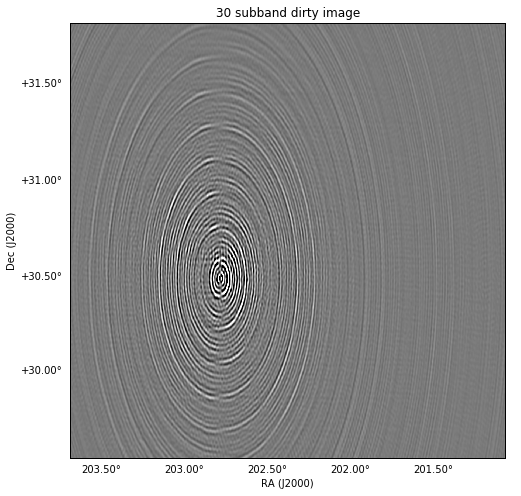

In [52]:
#Go ahead and quickly write image made above to fits file and display it inline. 
#For informative purposes
#so I did this but lost it - boo!
#redo quickly

#double-check I'm in the right location
print os.getcwd()

fits = lib.miriad('fits')
fits.in_ = invert.map
fits.out = invert.map +'.fits'
fits.op = 'xyout'

#now load a figure and display
fig=plt.figure(figsize=(8,8))

f1=aplpy.FITSFigure(fits.out,figure=fig,aspect='equal')
f1.show_grayscale()
f1.tick_labels.set_yformat('ddd.dd')
f1.tick_labels.set_xformat('ddd.dd')
f1.set_title('30 subband dirty image')

In [53]:
#Before starting looking at bandpass stability or doing any calibration,
#go ahead and look at uvedit 

print os.getcwd() #want to be in crosscal directory, create new file that will be used in later steps

uvedit = lib.miriad('uvedit')
uvedit.vis = invert.vis
uvedit.ra = '13,31,08.3'
uvedit.dec = '30,30,33'
uvedit.out = '3C286_uvedit.mir'

uvedit.go()

/data/adams/apertif/180503001/00/crosscal


['UVEDIT: version 1.8 24-Jul-2014',
 'UVEDIT: Editing visibility file: 3C286.mir',
 'UVEDIT: Writing visibilities to: 3C286_uvedit.mir']

In [58]:
#Since I'm curious how uvedit worked - make a quick image again


ccal = apercal.ccal(cfgfile_uvedit)

invert=lib.miriad('invert')
invert.vis = ccal.fluxcal
invert.map = 'dirty_nc_uvedit'
invert.beam= 'beam_dnc_uve'
invert.imsize='2049'
invert.cell='4'
invert.options='mfs,double'
invert.robust='-1'
invert.slop=0.9
invert.stokes='ii'
invert.line = 'chan,1920,4992' #only image part 30 subbands to save time
invert.go()


CROSSCAL - INFO : ### Configuration file /home/adams/apertif/BP/cfg/180503001_uvedit.cfg successfully read! ###


['',
 'invert: Revision 1.22, 2016/01/20 03:03:49 UTC',
 '',
 'Reading the visibility data ...',
 'Applying bandpass corrections to 3C286_uvedit.mir',
 'Applying gain corrections to 3C286_uvedit.mir',
 'Making MFS images',
 'Visibilities accepted: 137290486',
 'Mean Frequency(GHz):     1.32',
 'Sidelobe suppression area is 32768x32768 arcsec',
 ' ... this corresponds to uniform weighting',
 'Calculating the weights ...',
 'Applying the weights ...',
 'Theoretical rms noise: 5.056E-05',
 'Forming the beam ...',
 'Finished gridding  50% ...',
 'Forming Stokes I  image ...',
 'Completed 100% !']

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.952e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.525e-01 [aplpy.core]


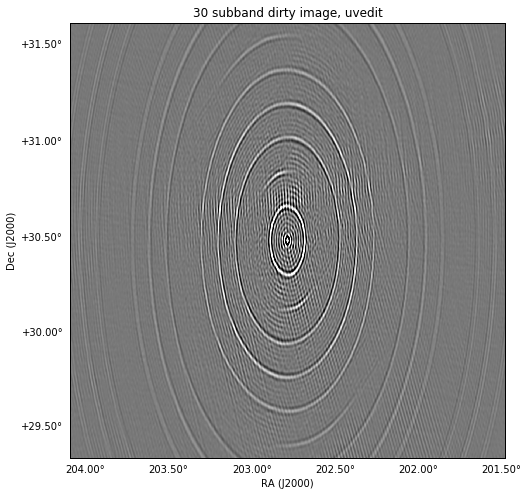

In [60]:
fits = lib.miriad('fits')
fits.in_ = invert.map
fits.out = invert.map +'.fits'
fits.op = 'xyout'
fits.go()

#now load a figure and display
fig=plt.figure(figsize=(8,8))

f1=aplpy.FITSFigure(fits.out,figure=fig,aspect='equal')
f1.show_grayscale()
f1.tick_labels.set_yformat('ddd.dd')
f1.tick_labels.set_xformat('ddd.dd')
f1.set_title('30 subband dirty image, uvedit')

Below is where the bandpass stability is explored; above is where the basic data preparation is undertaken (plus a quick look at an image). So now look at the bandpass stability. Note that bp.py needs to be updated for the fact that director has moved to "subs". But first create a new cfgfile with updated source name after the uvedit.

In [57]:
#Now derive calibration solutions for scan
#Do this for every 30 minutes

inttime='30'
bp.do_bp(cfgfile_uvedit,inttime='30')

CROSSCAL - INFO : ### Configuration file /home/adams/apertif/BP/cfg/180503001_uvedit.cfg successfully read! ###


3C286_uvedit.mir
calibration finished


In [61]:
#This reads the bandpass solutions derived above
#Unless the bp solution has been changed above, this doesn't need to be redone within a python session

#However, this reads the solutions into a numpy array in the active python session
#And so must be redone everytime the kernel is restarted.

values, freqs = bp.get_bpsols(cfgfile_uvedit)


print values.shape,freqs.shape

CROSSCAL - INFO : ### Configuration file /home/adams/apertif/BP/cfg/180503001_uvedit.cfg successfully read! ###


read calibration solutions into numpy array
(10, 11008, 24) (11008,)


In [62]:
#define the telescope names
#this is used generally throughout the notebook
#RTB was out of the array due to a uniboard issue
tnames = ('RT2','RT3','RT4','RT5','RT6','RT7','RT8','RT9','RTA','RTC')

In [63]:
#check where I am 
#Am about to start producing images, want to know where they will be written

import os
os.getcwd()


'/data/adams/apertif/180503001/00/crosscal'

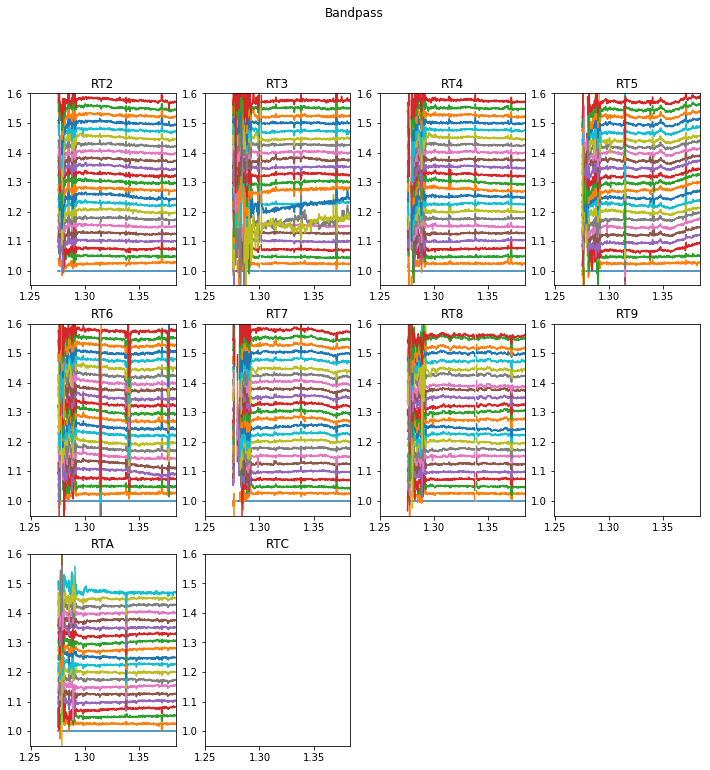

In [65]:
#now look at bandpasses over course of observation
#plot all antennas
#plot the normalized, offset bandpass solutions for each antenna
fig=bp.plot_bp_per_ant(values,freqs,tnames,nchan=16,nx=4,norm=True,
                       normscan=0,offset=0.025,ymax=1.6,xs=3,ys=4,ymin=0.95)

plt.savefig('bp_180503001_3C286_CB18.png')

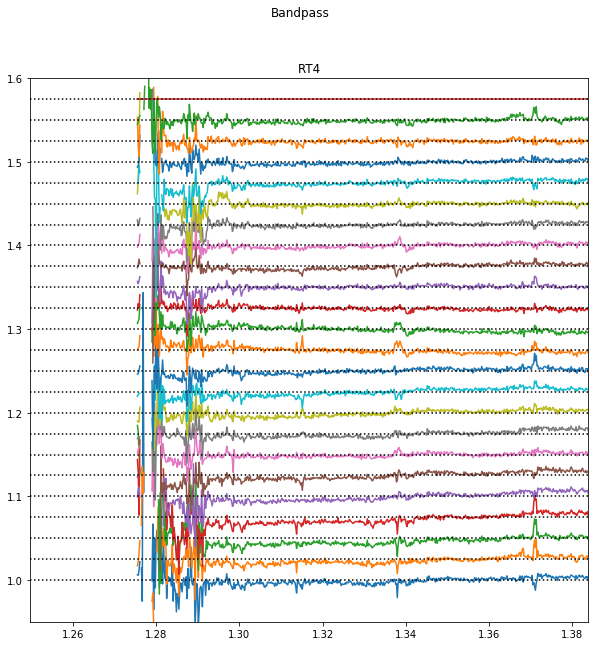

In [67]:
fig=bp.plot_bp_one_ant(values,freqs,2,'RT4',nchan=16,norm=True,normscan=-1,offset=0.025,ymin=0.95,ymax=1.6,plotsize=10)

#want to add a dotted line in same color to each scan that shows '1'
#print len(freqs)
for sol in range(values.shape[2]):
        plt.plot([freqs[0],freqs[-1]], [1+0.025*sol,1+0.025*sol],linestyle=':',c='k')
        
plt.savefig('bp_RT4_180503001_3C286_CB18.png')

Okay - lots of nice plots but what I really want to do is look at how bandpass stability compares to earlier element beam observations. Those observations are: 8022706_3C286 (before RT4 recabling), 8030111_3C286 (after RT4 recabling). They are located on happili-05. I looked at these before, located in data/adams/apertif/busydays and named withouts can numbers. So copy over the crosscal directory to happili-02 so that I can read solutions in here and lot them.

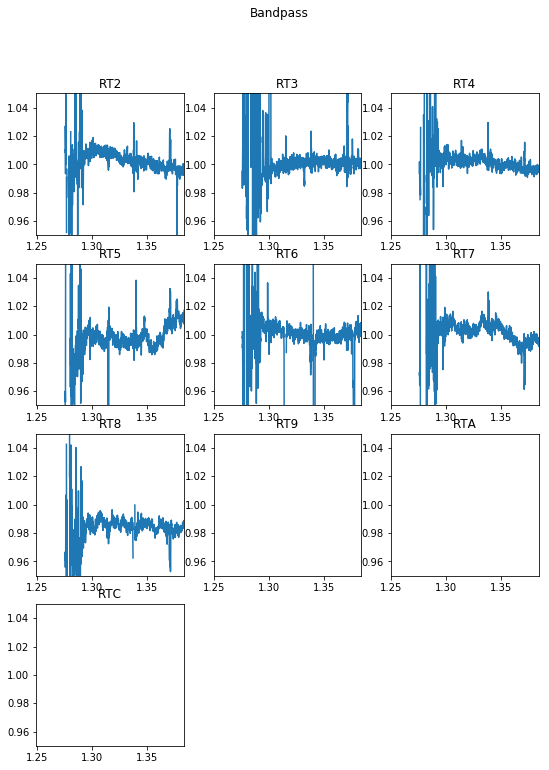

In [68]:
fig=bp.plot_last_bp_per_ant(values,freqs,tnames,nchan=8,nx=3,ymin=0.95,ymax=1.05,plotsize=3)

I can make lots of nice plots, but now we want to actually address the question of if we are meeting the science requirements. The requirements state that during a 12hr measurement the bandpass variation is less than 1:10^4 over a spectral range of 10 MHz. 
<br> <br>
To do this, will try taking 10 MHz windows and finding average rms. Will then want to plot this for center of every 10 MHz window (lose edges of bandpass). Can try with different channel smoothings. 
<br> <br>
Then will also want to get average deviation of all 10 MHz windows and show that as function of time for each antenna. Want to think about different things to plot: average deviation from one, total deviation, etc.

In [82]:
#let's start!
#define a function that will take bandpass solutions, bin a given set of channels, and then
#calculate rms in sliding 10 MHz windows
#Of course, this needs to be for normalized data

#input I will need: (values,freqs,nchan=8,normscan=0)

nchan = 8

def get_metrics(values,freqs,nchan=8,normscan=0,window=10):
    #window defined in MHz
    #first, get normalized data binned approporiately
    plotvals,plotfreqs = bp.get_norm_bpsols(values,freqs,nchan=nchan,normscan=normscan)

    #first, figure out how many channels of my averaged data are in 10 MHz
    chwid = 400./(512.*64.) #512 subbands across 400 MHz, 64 chans in each subband
    binchwid = chwid*np.float(nchan) #width of binned chan in MHz

    nin10 = (window/binchwid) #get number of chans in 10 MHz

    #now i want to create arrays to hold values I want to calculate
    #match vals in shape
    avgdev = np.empty(plotvals.shape)
    totdev = np.empty(plotvals.shape)
    avgtotdev = np.empty(plotvals.shape)
    mean = np.empty(plotvals.shape)

    #now iterate through antennas and solution intervals
    #use pandas 'rolling' to calculate things in windows
    for ant in range(plotvals.shape[0]):
        for sol in range(plotvals.shape[2]):
            #if i just want running mean, cumsum is a good way to do that:
            #turn out pandas has great functionality for this, and is in apercal environment
            fs = pd.Series(plotvals[ant,:,sol],index=plotfreqs)
            window_mean = fs.rolling(window=np.int(nin10)).mean()
            
            fs_zero = pd.Series((plotvals[ant,:,sol]-1.),index=plotfreqs)
            window_avgdev = fs_zero.rolling(window=np.int(nin10)).mean()
            
            fs_abs = pd.Series(np.abs((plotvals[ant,:,sol]-1.)),index=plotfreqs)
            window_totdev = fs_abs.rolling(window=np.int(nin10)).sum()
            window_avgtotdev = fs_abs.rolling(window=np.int(nin10)).mean()
            
            #fs.rolling(window=10).mean().plot(style='k')
            avgdev[ant,:,sol] = window_avgdev
            totdev[ant,:,sol] = window_totdev
            avgtotdev[ant,:,sol] = window_avgtotdev
            mean[ant,:,sol] = window_mean

    return mean,avgtotdev


In [83]:
#now maybe have a function for getting mean, avgdev and totdev
#so let's move to plotting
#want to do antenna based plots, plotting different vals, first
#also want to plot a single time to start
#can adapt/play with this as needed

def plot_per_ant_metrics(values,freqs,ant,plotscan=-1,nchan=8,normscan=0,window=10):
    #choose which scan to plot
    #first get data, just in case I want to plot it also
    plotvals,plotfreqs = bp.get_norm_bpsols(values,freqs,nchan=nchan,normscan=normscan)
    
    #then get metrics
    mean,avgtotdev = get_metrics(values,freqs,nchan=nchan,normscan=normscan,window=window)
    
    #for now, think I only care about mean, avgtotdev
    
    #now plot
    #want to plot solution, normalized solution (same y-range), 
    #avgtot dev, max(avgtotdev) over time
    #get the information for that last part:
    
    maxdev = np.empty(plotvals.shape[2])
    
    for sol in range(plotvals.shape[2]):
        maxdev[sol] = np.nanmax(avgtotdev[ant,:,sol])
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
    
    f1 = plotfreqs[0]
    f2 = plotfreqs[-1]
    norm1 = 0.97
    norm2 =1.03
    
    dev1 = 0
    dev2 = 0.01
    
    sol1=0
    sol2=plotvals.shape[2] -1
    
    ax1.plot(plotfreqs,plotvals[ant,:,plotscan],c='k')
    ax1.plot([f1,f2],[1,1],c='red')
    ax1.set_title('Normalized solution')
    #ax1.axis([f1,f2,norm2,norm2])
    
    ax2.plot(plotfreqs,mean[ant,:,plotscan],c='k')
    ax2.plot([f1,f2],[1,1])
    ax2.set_title('Average over '+str(window)+'MHz window')
    #ax2.axis([f1,f2,norm2,norm2])
    
    ax3.plot(plotfreqs,avgtotdev[ant,:,plotscan],c='k')
    ax3.set_title('Total average deviation over '+str(window)+'MHz window')   
    ax3.axis([f1,f2,dev1,dev2])
    
    ax4.plot(np.arange(plotvals.shape[2]),maxdev,c='k')
    ax4.set_title('Maximum deviation over '+str(window)+'MHz window') 
    ax4.set_xlabel('Solution interval')
    ax4.axis([sol1,sol2,dev1,dev2])
    
    return fig


<IPython.core.display.Javascript object>


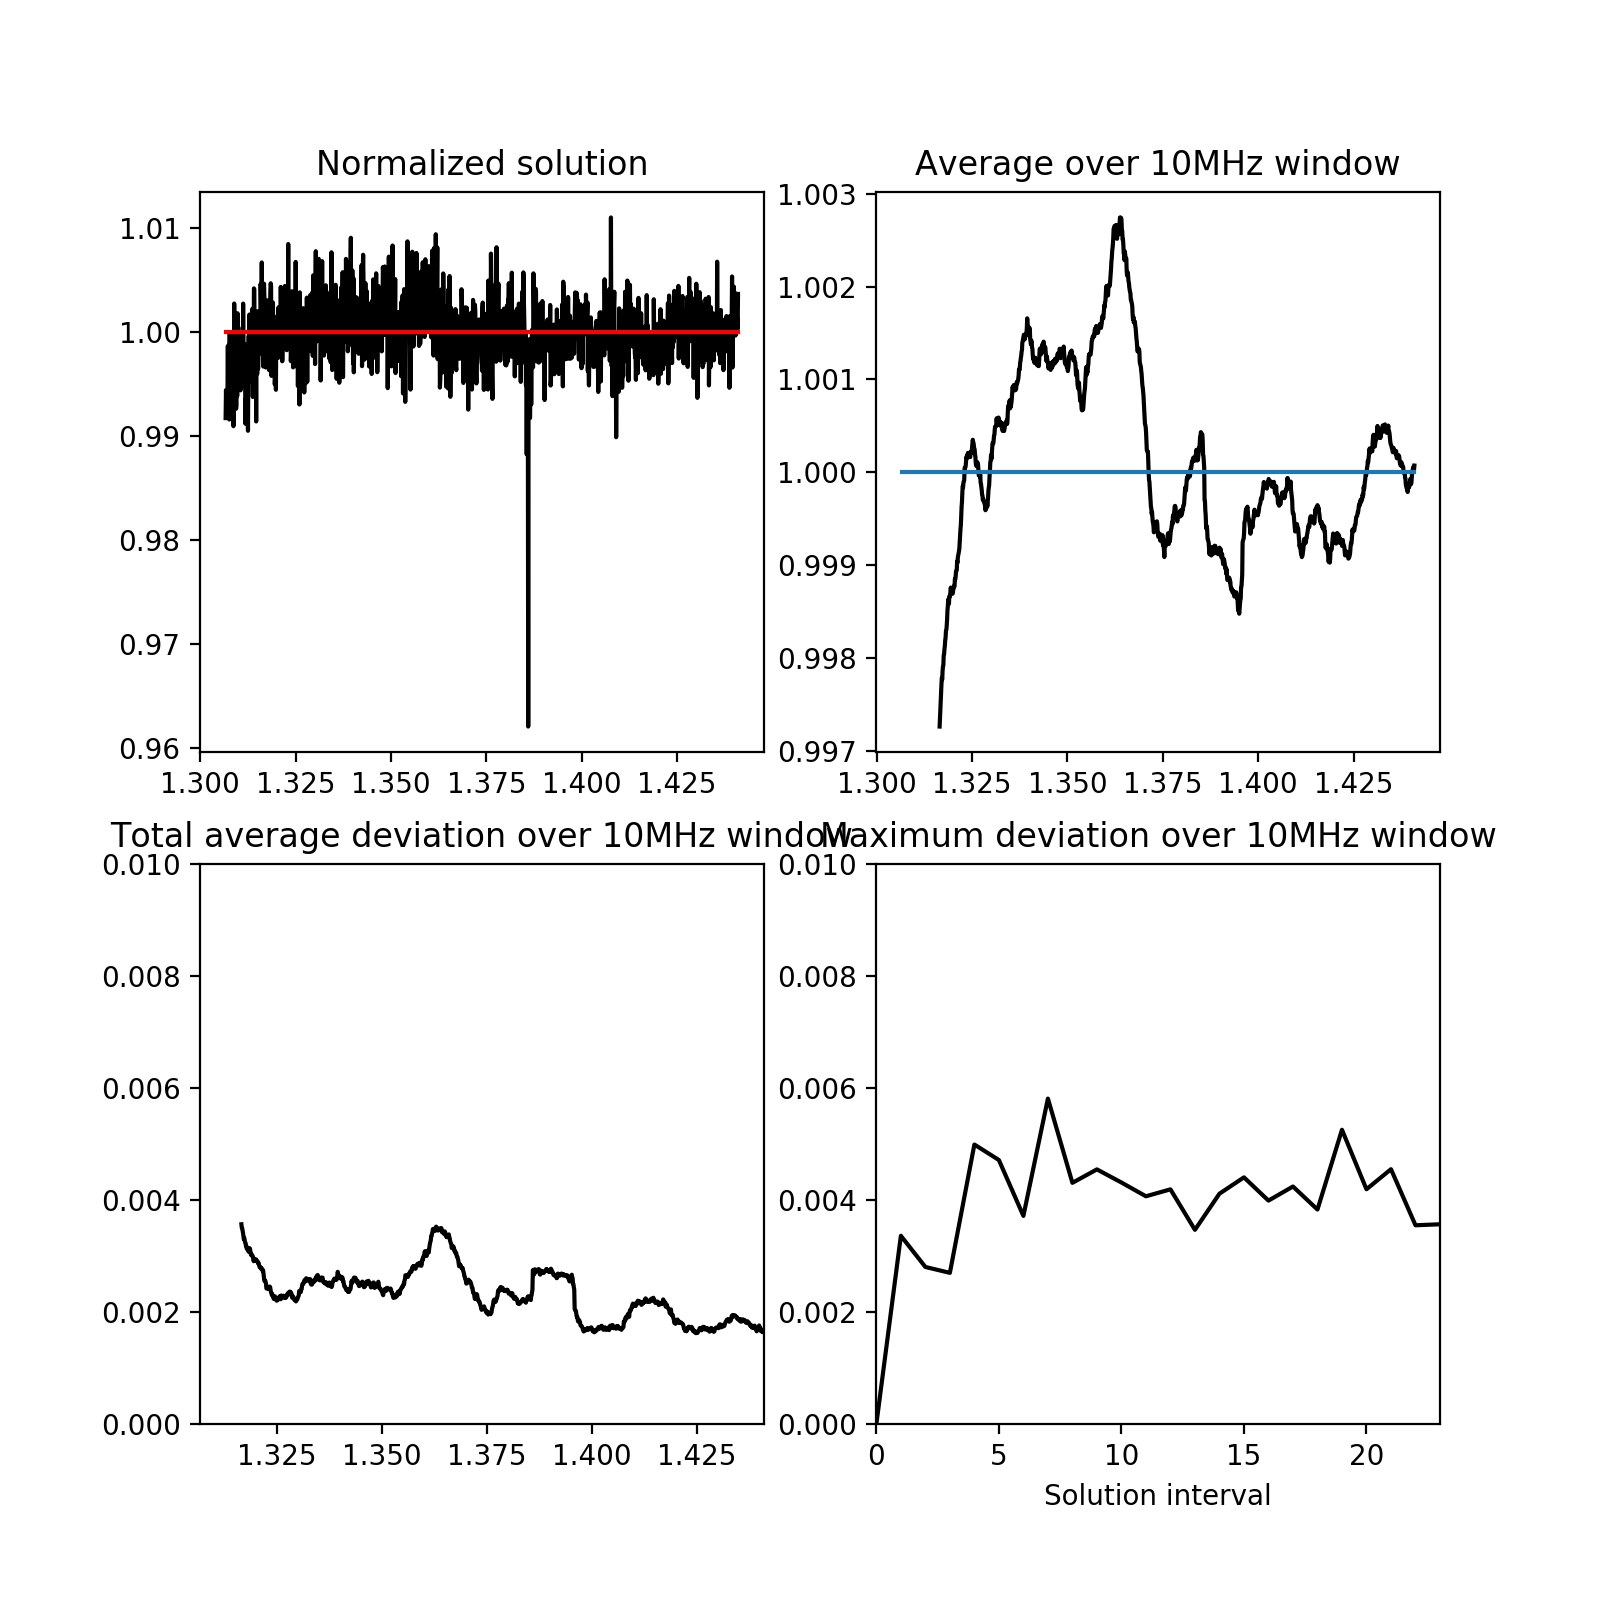

In [84]:
fig = plot_per_ant_metrics(values,freqs,2)

<IPython.core.display.Javascript object>


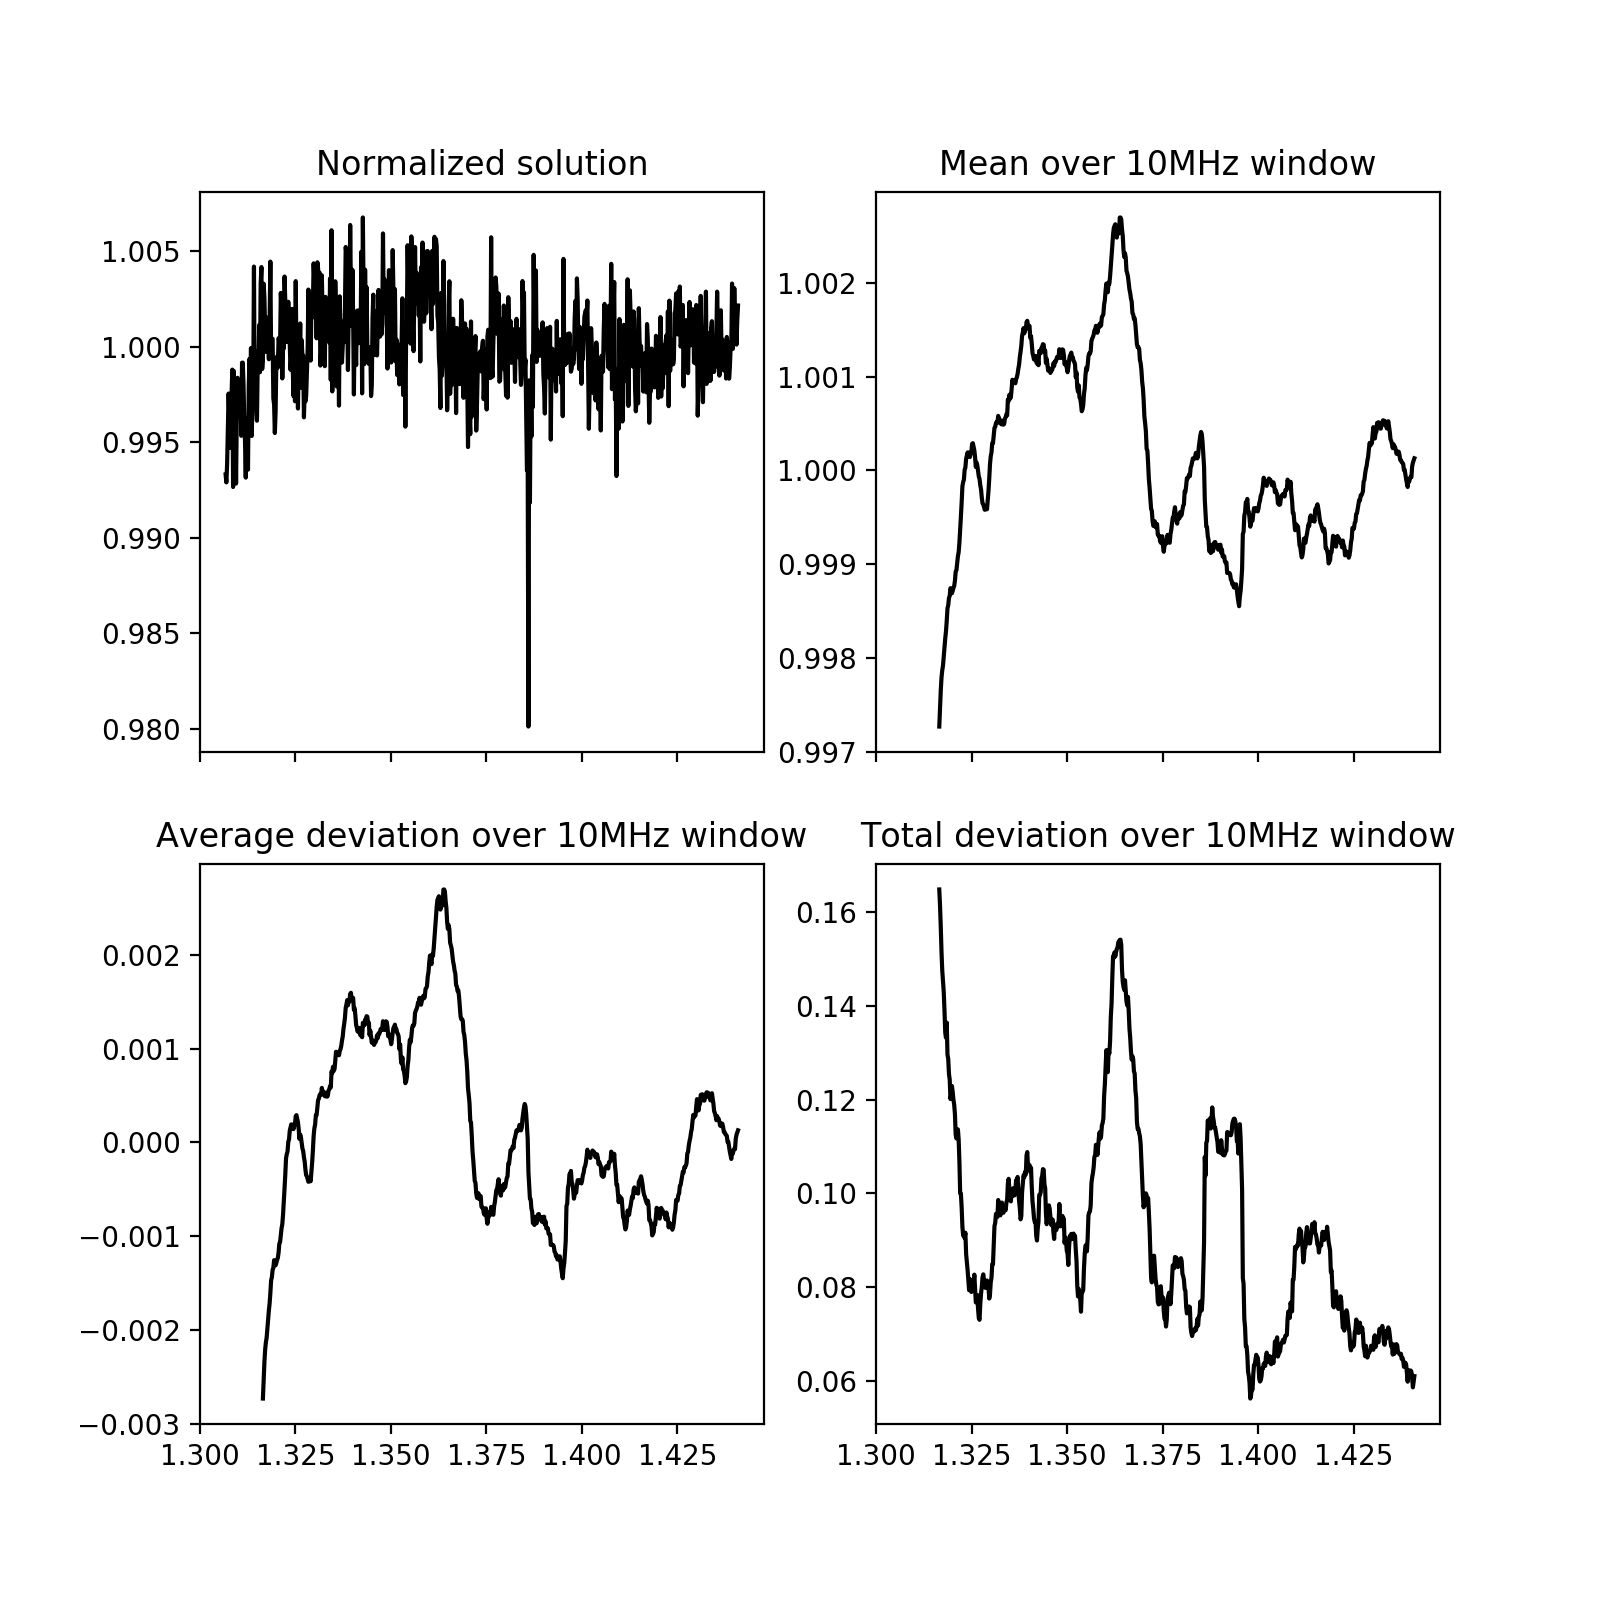

In [51]:
fig = plot_per_ant_metrics(values,freqs,2,nchan=16,window=10)

<IPython.core.display.Javascript object>


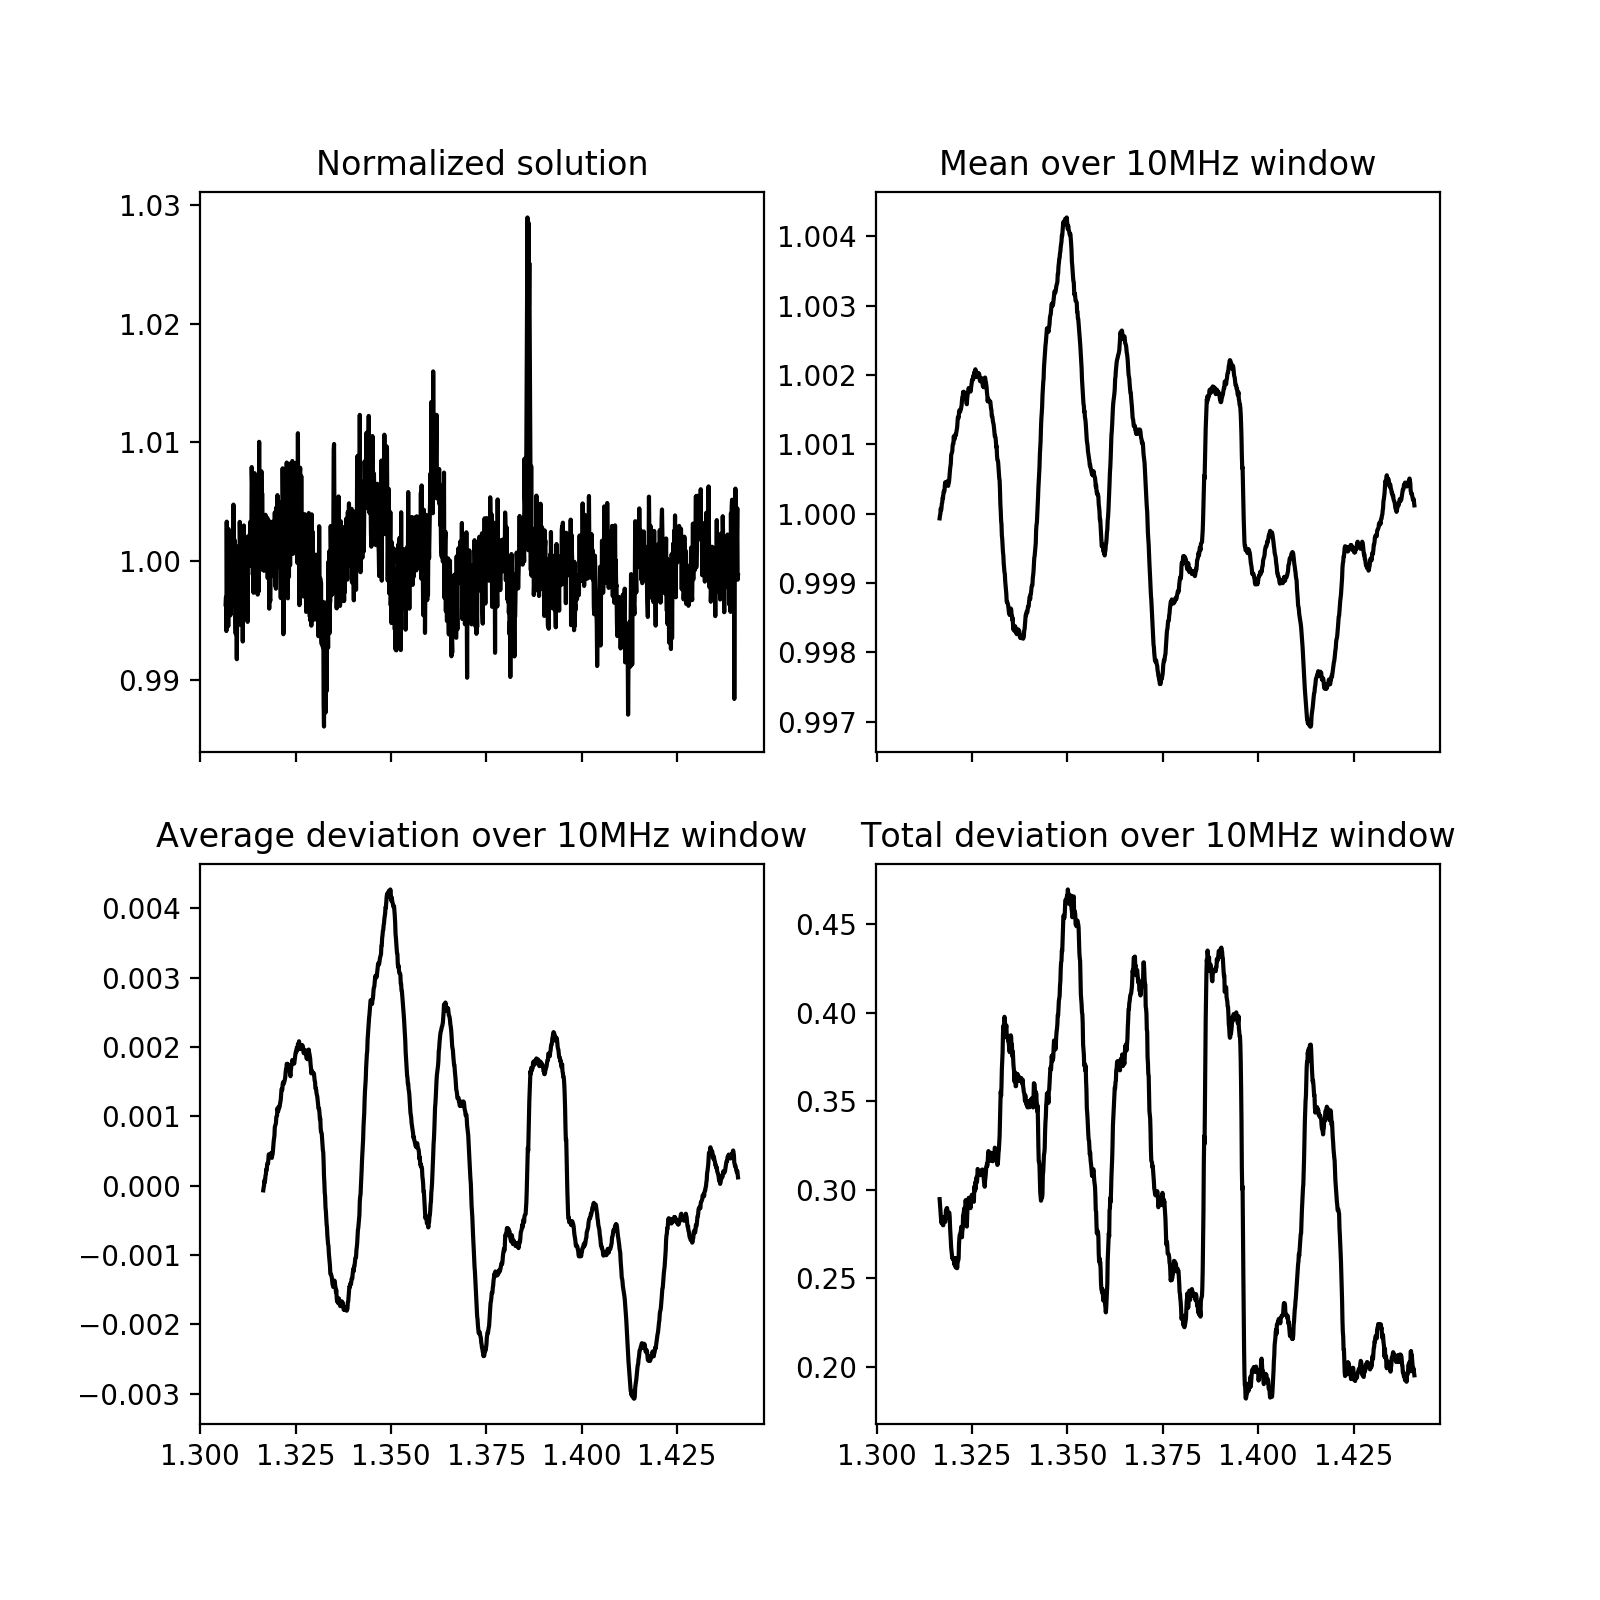

In [49]:
fig = plot_per_ant_metrics(values,freqs,5,nchan=8)

In [ ]:
#Useful code for plotting in pandas

fs = pd.Series(plotvals[0,:,-1],index=plotfreqs)
fs.plot(style='k--')
fs.rolling(window=10).mean().plot(style='r:')
fs.rolling(window=np.int(nin10)).mean().plot(style='r')